In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy

from gw150814_simulator import defaults, GW150814_Additive

import matplotlib.pyplot as plt
plt.style.use('mystyle.mplstyle')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
correlation_scales = torch.tensor([2]).int() * 8
# gw150814_post = torch.load('./stores/gw150814_post_d8_m1_1010k.pt')
# gw150814_noise = torch.load('./stores/gw150814_noise_d8_m1_10M.pt')
gw150814_samples = {'mu': torch.ones(10, 16384), 'noise': torch.ones(10, 16384)}
# gw150814_samples = torch.load('./stores/gw150814_samples_d8_m1_500k.pt')
simulator = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    bounds=torch.tensor([3000]), #1.2341, 0.5696, 0.3403]), 
    dtype=torch.float32,
    correlation_scales = correlation_scales
)

times = simulator._process(simulator.times)
Nbins = simulator.Nbins
Nbins

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


16384

In [4]:
import jax.numpy as jnp

def check_plot(dist):
    dist_f = simulator.time_to_frequency_domain(dist)
    dist_t = simulator.frequency_to_time_domain(dist_f * simulator.filter)

    print(jnp.abs(dist_f).max())
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.loglog(simulator.frequencies, jnp.abs(dist_f))
    plt.loglog(simulator.frequencies, jnp.abs(dist_f) * simulator.filter)
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')

    plt.subplot(132)
    plt.plot(simulator.times, dist)
    plt.plot(simulator.times, dist_t)
    # plt.xlim(-0.1001, 0.1001)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(133)
    plt.plot(simulator._process(simulator.times), simulator._process(np.array(dist)))
    plt.plot(simulator._process(simulator.times), simulator._process(np.array(dist_t)))
    plt.xlabel('Processed Time')
    plt.ylabel('Processed Amplitude')

    plt.tight_layout()

0.014060171481560246


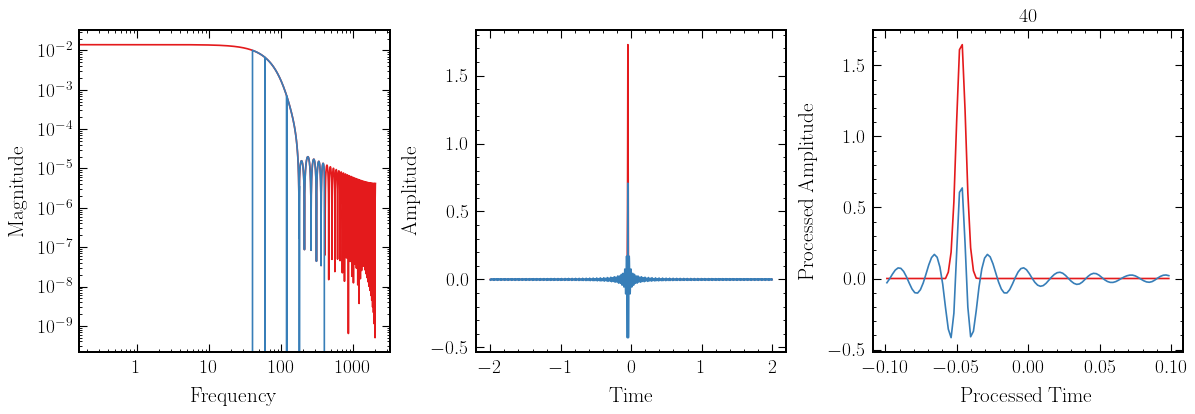

In [5]:
ni = torch.zeros([1, 16384])
ni[0, 8000] = 1

b = torch.tensor([10])
simulator.correlation_scales =  torch.tensor([40]).int() 
epsilon_sim =  (2 * b.unsqueeze(0).unsqueeze(2) * torch.rand(ni.shape, device=ni.device, dtype= ni.dtype) - b.unsqueeze(0).unsqueeze(2)) * ni.unsqueeze(1)
cni_sim = torch.stack([simulator._conv1d(ni*epsilon_sim[:, i_c], int(c)) for i_c, c in enumerate(simulator.correlation_scales)], axis=1)

dist = cni_sim[0,0]   
# dist = epsilon_sim[0, 0]

check_plot(dist)
plt.title(f'{simulator.correlation_scales.item()}');

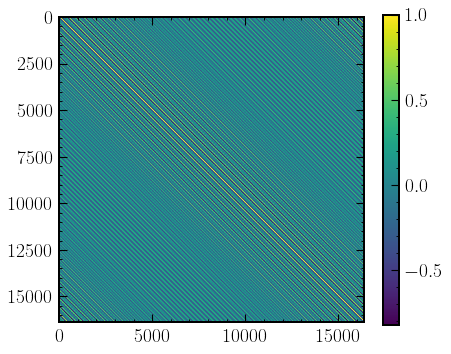

In [ ]:
psd_t = simulator.frequency_to_time_domain(simulator.psd * simulator.filter)

noise = []
for _ in range(100):
    noise.append(simulator.generate_time_domain_noise())
noise = jnp.stack(noise)

# C_ij = PSD_t[i-j]
size = 16384
covariance_matrix = np.zeros((size, size))
autocorr = psd_t
# for i in range(size):
#     for j in range(size):
#         covariance_matrix[i, j] = autocorr[abs(i - j)]
covariance_matrix = scipy.linalg.toeplitz(autocorr)

# Normalize
diag = np.sqrt(np.diag(covariance_matrix))

plt.imshow(covariance_matrix/ np.outer(diag, diag))
plt.colorbar();
# Downsample after building the covariance matrix